# 2D convolution network with Adam optimizer

In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from PIL import Image

import numpy as np
from numpy.testing import assert_allclose, assert_equal
import matplotlib
import matplotlib.pyplot as plt
import os

# initialization and check if dataset got proper size

path = '/home/ubuntu/zdjecia/'
# path = '/home/oziomek/licencjat/kostki/zdjecia/'
listing = os.listdir(path)
print(listing)
num_samples = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        num_samples += len(os.listdir(path + folder + '/' + str(i)))
assert_equal(100800, num_samples)
print(num_samples)

['woodOnRed', 'blackOnRed', 'redOnRed', 'redOnRed_white', 'navyOnWhite', 'blackOnBlack', 'whiteOnBlue', 'greenOnWhite', 'navyOnBlue', 'stainOnWhite', 'hardLight', 'whiteOnRed_distance', 'whiteOnBlack', 'whiteOnRed', 'greenOnGreen']
100800


In [4]:
# load all data into numpy array
immatrix = np.array(
    [np.array(Image.open(path + folder + '/' + str(i) + '/' + file)).flatten() 
         for folder in os.listdir(path)
             for i in range(1, 7) 
                 for file in os.listdir(path + folder + '/' + str(i))], 'f')

In [5]:
print(immatrix.shape)

(100800, 4096)


In [6]:
labels = np.ones((num_samples, ), dtype=int)
counter = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        samples = len(os.listdir(path + folder + '/' + str(i)))
        labels[counter:counter+samples] = i-1
        counter += samples

In [7]:
# randomize data with const random_state
data, label = shuffle(immatrix, labels, random_state=13)

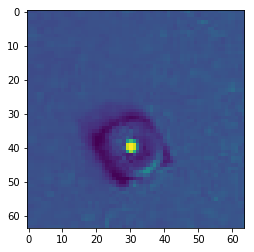

There are 1 dots, number is 4254


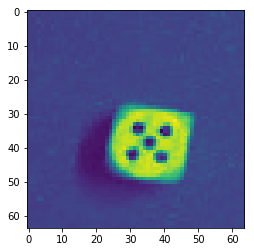

There are 5 dots, number is 2213


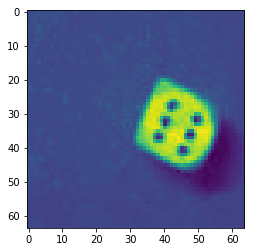

There are 6 dots, number is 2620


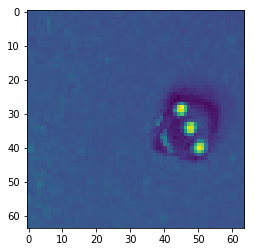

There are 3 dots, number is 7147


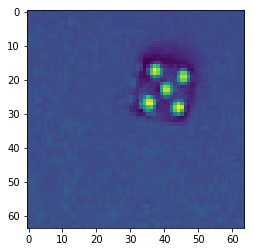

There are 5 dots, number is 9759


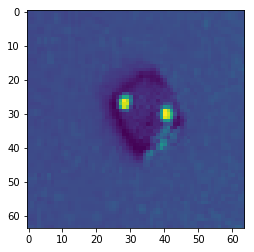

There are 2 dots, number is 5774


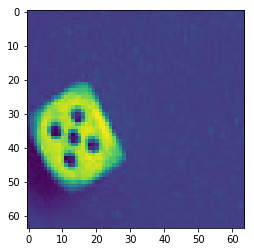

There are 5 dots, number is 2133


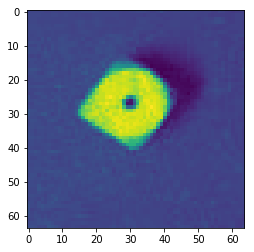

There are 1 dots, number is 462


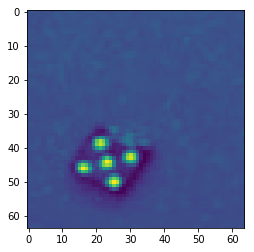

There are 5 dots, number is 9926


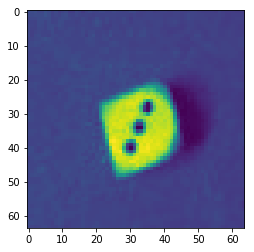

There are 3 dots, number is 1296


In [8]:
# show randomly chosen image
rows, cols = 64, 64
labels_values = 6
train_data = [data, label]
import random
for i in range(10):
    random_image = random.randint(0, 10080)
    img=immatrix[random_image].reshape(rows, cols)
    plt.imshow(img)
    plt.show()
    print("There are {} dots, number is {}".format(labels[random_image] + 1, random_image))

In [9]:
(X, y) = (train_data[0], train_data[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [10]:
# reshape to [color_layers][pixels_height][pixels_width], color_layers equal to 2 because photos are in GRAYSCALE
X_train = X_train.reshape(X_train.shape[0], 1, rows, cols).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, rows, cols).astype('float32')

# normalize to 0-1
X_train /= 255
X_test /= 255

print(X_train.shape, X_test.shape)

(80640, 1, 64, 64) (20160, 1, 64, 64)


In [11]:
# onehot
y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)
print(y_train.shape, y_test.shape)

(80640, 6) (20160, 6)


In [12]:
# create sequential model with 2NN layers
def base_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=(1, 64, 64), data_format='channels_first', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(784, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(196, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(labels_values, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
# summarize model and apply checkpoints
model = base_model()
print(model.summary())
filepath = 'model2adam-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 60, 60)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 30, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 26, 32)        48032     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 26, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23296)             0         
_______________________________________________________

In [14]:
# visualization of a model
plot_model(model, to_file='model2adam_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=2048, verbose=1, callbacks=callbacks_list)

Train on 80640 samples, validate on 20160 samples
Epoch 1/25
80640/80640 [==============================] - 38s 472us/step - loss: 1.7946 - acc: 0.1720 - val_loss: 1.7887 - val_acc: 0.1954
Epoch 2/25
80640/80640 [==============================] - 32s 399us/step - loss: 1.7482 - acc: 0.2305 - val_loss: 1.6694 - val_acc: 0.2805
Epoch 3/25
80640/80640 [==============================] - 32s 397us/step - loss: 1.6498 - acc: 0.2722 - val_loss: 1.6630 - val_acc: 0.2481
Epoch 4/25
80640/80640 [==============================] - 32s 398us/step - loss: 1.5478 - acc: 0.3140 - val_loss: 1.5447 - val_acc: 0.2879
Epoch 5/25
80640/80640 [==============================] - 32s 395us/step - loss: 1.4486 - acc: 0.3574 - val_loss: 1.3281 - val_acc: 0.4299
Epoch 6/25
80640/80640 [==============================] - 32s 396us/step - loss: 1.3914 - acc: 0.3847 - val_loss: 1.3925 - val_acc: 0.3625
Epoch 7/25
80640/80640 [==============================] - 32s 400us/step - loss: 1.3563 - acc: 0.3995 - val_loss: 1.

In [16]:
score = model.evaluate(X_test, y_test, verbose=1)

20160/20160 [==============================] - 4s 205us/step


In [17]:
print(history.history.keys())
print("Accuracy: %.2f%%" % (score[1]*100))
print('Test loss:', score[0])
print('Test accuracy', score[1])

dict_keys(['val_loss', 'val_acc', 'acc', 'loss'])
Accuracy: 55.64%
Test loss: 1.0110950591072203
Test accuracy 0.5564484126984127


In [18]:
print('training results:')
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(score[i]))

training results:
loss: 1.0110950591072203
acc: 0.5564484126984127


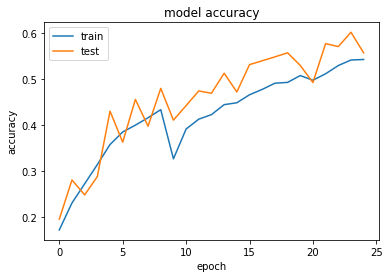

In [19]:
#summarize for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

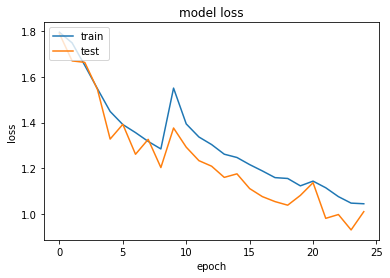

In [20]:
#summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
model_json = model.to_json()
with open('model2adam_model.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model2adam_weights.h5')
print('Saved model weights')

Saved model weights


In [23]:
new_model = load_model('model2adam-25-1.0456.h5')
# check in models are similar to the given tolerance
assert_allclose(model.predict(X_train),
               new_model.predict(X_train),
               1e-4)

In [24]:
filepath = 'model2adam_continue-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [25]:
new_history = new_model.fit(X_train, y_train, epochs=10, batch_size=2048, callbacks=callbacks_list)

Epoch 1/10
80640/80640 [==============================] - 30s 367us/step - loss: 1.0403 - acc: 0.5435
Epoch 2/10
80640/80640 [==============================] - 30s 368us/step - loss: 1.0154 - acc: 0.5556
Epoch 3/10
80640/80640 [==============================] - 30s 367us/step - loss: 1.0015 - acc: 0.5615
Epoch 4/10
80640/80640 [==============================] - 30s 368us/step - loss: 0.9778 - acc: 0.5741
Epoch 5/10
80640/80640 [==============================] - 30s 366us/step - loss: 0.9974 - acc: 0.5647
Epoch 6/10
80640/80640 [==============================] - 30s 368us/step - loss: 0.9556 - acc: 0.5836
Epoch 7/10
80640/80640 [==============================] - 30s 367us/step - loss: 0.9543 - acc: 0.5848
Epoch 8/10
80640/80640 [==============================] - 30s 367us/step - loss: 0.9359 - acc: 0.5905
Epoch 9/10
80640/80640 [==============================] - 30s 368us/step - loss: 0.9209 - acc: 0.5976
Epoch 10/10
80640/80640 [==============================] - 30s 369us/step - loss: 

In [26]:
new_score = new_model.evaluate(X_test, y_test, verbose=1)
print('training results:')
for i in range(len(new_model.metrics_names)):
    print(str(new_model.metrics_names[i]) + ": " + str(new_score[i]))

20160/20160 [==============================] - 4s 201us/step
training results:
loss: 0.8077277978261311
acc: 0.6529761904761905


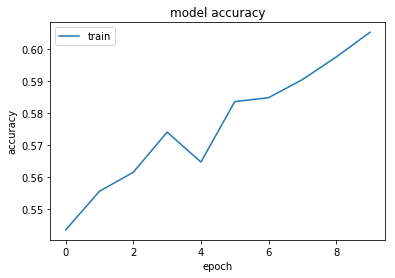

In [29]:
plt.plot(new_history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

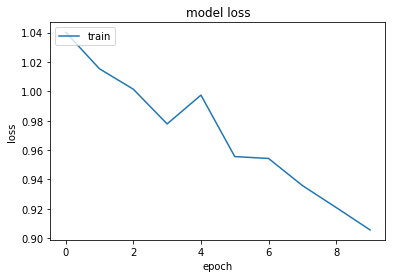

In [31]:
plt.plot(new_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
model_json = model.to_json()
with open('model2adam_continue.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model2adam_weights_continue.h5')
print('Saved model weights')

Saved model weights
